In [1]:
# various pandas, numpy
import pandas as pd
import numpy as np
import pandas.io.data as web
from datetime import datetime
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import matplotlib.mlab as mlab
# plotting

import matplotlib.pyplot as plt

# make plots inline
%matplotlib inline

# formatting options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 82) 
pd.set_option('precision', 7)

C:\Users\Jaime\Anaconda2\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
def calc_portfolio_var(returns, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [3]:
DJIA = pd.read_csv('DJIA-Data.csv')

In [5]:
calc_portfolio_var(DJIA)

9.2260545534259251

In [6]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [7]:
sharpe_ratio(DJIA)

0.34360600023463866

In [8]:
# function to minimize
def y_f(x): return 2+x**2

In [9]:
scopt.fmin(y_f, 1000)

Optimization terminated successfully.
         Current function value: 2.000000
         Iterations: 27
         Function evaluations: 54


array([ 0.])

In [10]:
def negative_sharpe_ratio_n_minus_1_stock(weights, 
                                          returns, 
                                          risk_free_rate=0):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [11]:
def optimize_portfolio(returns, risk_free_rate=0):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(returns.columns.size-1, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, 
                    w0, args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [12]:
# optimize our portfolio
optimize_portfolio(DJIA)

(array([ 0.03795913,  0.02253121,  0.03417837,  0.03828585,  0.00568042,
         0.00800131,  0.02233348,  0.01485497,  0.01803012,  0.00593367,
         0.02484326,  0.03476146,  0.05653841, -0.00080404,  0.02127053,
         0.04137479,  0.03498348,  0.01574022,  0.03325537,  0.04102226,
         0.0785865 ,  0.02657206,  0.02164442,  0.03630576,  0.09072742,
         0.02074175,  0.03653903,  0.06663439,  0.06811117,  0.04336323]),
 0.40869395740495079)

In [31]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    return np.sqrt(port_var) + penalty # objective function

In [32]:
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        '''
        if not results.success: # handle error
            raise Exception(results.message)
        '''
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [33]:
frontier_data = calc_efficient_frontier(DJIA)

In [34]:
frontier_data['Stds'][:5]

[4.961443,
 4.6705420000000002,
 4.4086959999999999,
 4.177511,
 3.9586899999999998]

In [35]:
frontier_data['Means'][:5]

[-0.047,
 -0.025700000000000001,
 -0.0044000000000000003,
 0.016899999999999998,
 0.038199999999999998]

In [36]:
frontier_data['Weights'][:5]

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e-05,   1.00000000e-05,
          0.00000000e+00,   1.00000000e-05,   0.00000000e+00,
          1.00000000e-05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e-05,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.08892,  0.     ,  0.     ,
         0.     ,  0.91108,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]),
 array([ 0.     ,  0.     ,  0.     

In [37]:
def plot_efficient_frontier(frontier_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(frontier_data['Stds'], frontier_data['Means'], '--'); 
    plt.savefig('5104OS_09_20.png', bbox_inches='tight', dpi=300)

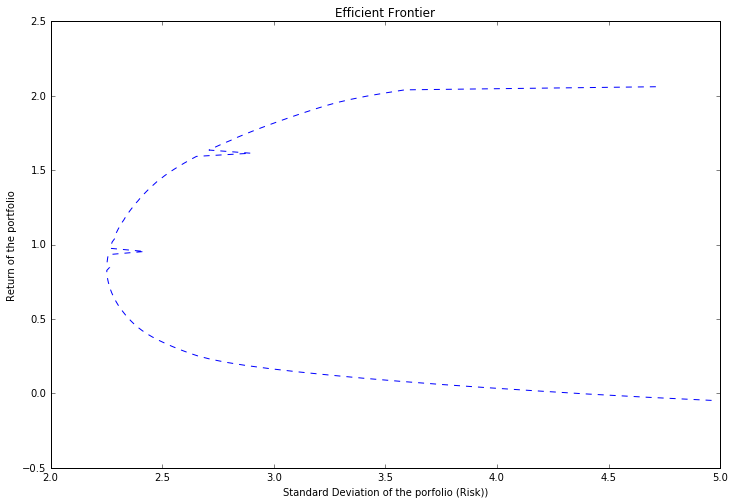

In [38]:
plot_efficient_frontier(frontier_data)